In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os



In [ ]:
img_dir = '/Users/majer/Desktop/Brain_CT/agyikepek_3_osztaly/kepek'

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

images = []
images = load_images_from_folder(img_dir)
labels = os.listdir(img_dir)


In [3]:
labels = os.listdir(img_dir)
print(len(images))
print(len(labels))
print(labels)
for i in range(len(labels)):
    tmp = labels[i].split('.')
    labels[i] = tmp[0][-1]

print(labels)


3064
3064
['1000_3.png', '1001_3.png', '1002_3.png', '1003_3.png', '1004_3.png', '1005_3.png', '1006_3.png', '1007_3.png', '1008_3.png', '1009_3.png', '100_1.png', '1010_3.png', '1011_3.png', '1012_3.png', '1013_3.png', '1014_3.png', '1015_3.png', '1016_3.png', '1017_3.png', '1018_3.png', '1019_3.png', '101_1.png', '1020_3.png', '1021_3.png', '1022_3.png', '1023_3.png', '1024_3.png', '1025_3.png', '1026_3.png', '1027_3.png', '1028_3.png', '1029_3.png', '102_1.png', '1030_3.png', '1031_3.png', '1032_3.png', '1033_3.png', '1034_3.png', '1035_3.png', '1036_3.png', '1037_3.png', '1038_3.png', '1039_3.png', '103_1.png', '1040_3.png', '1041_3.png', '1042_3.png', '1043_3.png', '1044_3.png', '1045_3.png', '1046_3.png', '1047_3.png', '1048_3.png', '1049_3.png', '104_1.png', '1050_3.png', '1051_3.png', '1052_3.png', '1053_3.png', '1054_3.png', '1055_3.png', '1056_3.png', '1057_3.png', '1058_3.png', '1059_3.png', '105_1.png', '1060_3.png', '1061_3.png', '1062_3.png', '1063_3.png', '1064_3.png', '

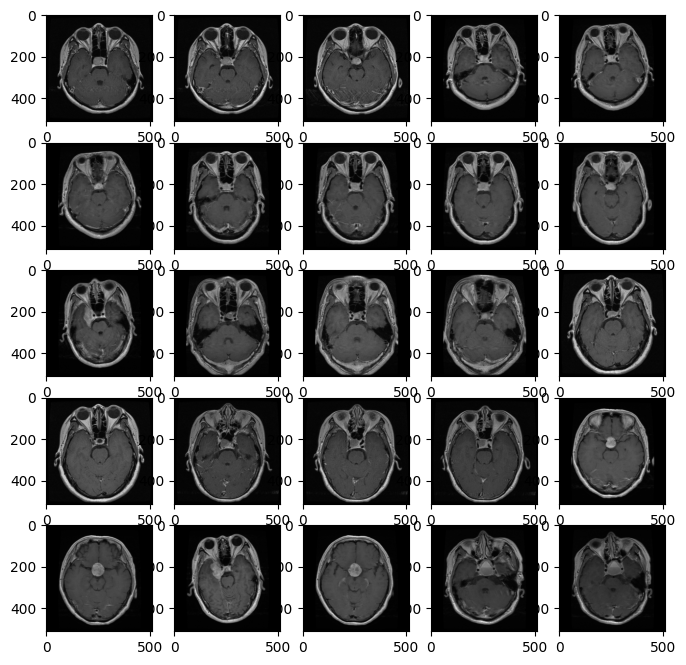

In [4]:
fig, axes = plt.subplots(5,5, figsize=(8,8))
for i,ax in enumerate(axes.flat):
    ax.imshow(images[i])

In [ ]:
df = pd.DataFrame()
df['label']=labels
df['image']=images



In [6]:
df.head()

,label,image
0,3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
